# Grad-CAM : Visual Explanations from Deep Networks via Gradient-based Localization

Referance : https://arxiv.org/pdf/1610.02391.pdf

In [1]:
import tensorflow as tf
import numpy as np
import os

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.set_printoptions(precision=10,suppress=True)

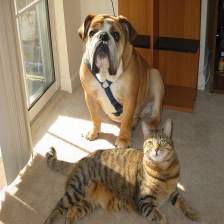

In [2]:
# Remove the existed image.
if os.path.exists('/root/.keras/datasets/sample_image.png'):
    os.remove('/root/.keras/datasets/sample_image.png')

# Download an image from URL.
img_path = 'https://raw.githubusercontent.com/Lynchee/public_project/main/gradsCAM/demo.png'
display(Image(img_path))

57344/52183 [================================] - 0s 0us/step


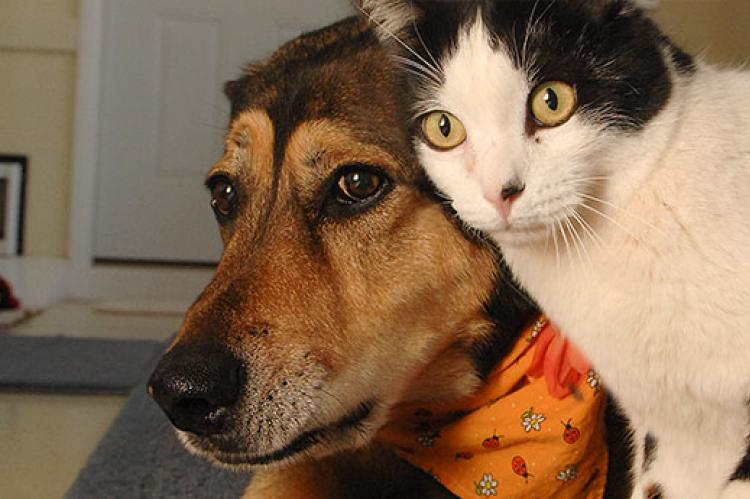

In [3]:
if os.path.exists('/root/.keras/datasets/sample_image.png'):
    os.remove('/root/.keras/datasets/sample_image.png')

# Download an image from URL.
img_url = "https://raw.githubusercontent.com/Lynchee/public_project/main/gradsCAM/DogCat.png"
img_path = tf.keras.utils.get_file('sample_image.png',img_url)
display(Image(img_path))

##Grad-CAM

In [11]:
# Create linear dense layer.
class Linear(tf.keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        weight_last_layer = model.layers[-1].weights[0]
        bias_last_layer = model.layers[-1].weights[1]
        self.w = tf.Variable(initial_value= weight_last_layer,trainable=True,)
        self.b = tf.Variable( initial_value=bias_last_layer, trainable=True )

    def call(self, inputs,model):
        return tf.matmul(inputs, self.w) + self.b
        
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names,selected_classth = None,softmax=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names[:-1]:
        x = model.get_layer(layer_name)(x)

    # Create the last linear layer before the softmax activation function
    linear_layer = Linear(model.output_shape[-1], x.shape[-1])
    x = linear_layer(x,model)
    if softmax:
        x = tf.keras.activations.softmax(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)

        # we focus on specifi calss otherwise we only choose the maximum preds scores
        if selected_classth:
            top_pred_index = selected_classth
        else:
            top_pred_index = tf.argmax(preds[0])
            
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    original_last_conv_layer_output = last_conv_layer_output.copy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    ori_heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(ori_heatmap, 0) / np.max(ori_heatmap)
    # heatmap = heatmap/ np.max(heatmap)
    return heatmap,last_conv_layer_output,pooled_grads,grads,original_last_conv_layer_output,top_class_channel,ori_heatmap

# Choose the model and preprocessing module.
def create_model(model_name):
    if model_name is 'EfficientNetB7':
        model = tf.keras.applications.EfficientNetB7(include_top=True, weights="imagenet")
        img_size = model.input_shape[1:3]
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        decode_predictions = tf.keras.applications.efficientnet.decode_predictions
        last_conv_layer_name = "top_activation"
        classifier_layer_names = [
            "avg_pool",
            "top_dropout",
            "predictions",
        ]

    elif model_name is 'VGG16':
        model =tf.keras.applications.VGG16(include_top=True, weights="imagenet")
        img_size = model.input_shape[1:3]
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
        decode_predictions = tf.keras.applications.vgg16.decode_predictions
        last_conv_layer_name = 'block5_pool'
        classifier_layer_names = [
            "flatten",
            "fc1",
            "fc2",
            "predictions"
        ]

    elif model_name is 'VGG19':
        model = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
        img_size = model.input_shape[1:3]
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
        decode_predictions = tf.keras.applications.vgg19.decode_predictions
        last_conv_layer_name = 'block5_pool'
        classifier_layer_names = [
            "flatten",
            "fc1",
            "fc2",
            "predictions"
        ]
    elif model_name is 'Resnet50':
        model = tf.keras.applications.resnet50.ResNet50(include_top=True, weights="imagenet")
        img_size = model.input_shape[1:3]
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        decode_predictions = tf.keras.applications.resnet50.decode_predictions
        last_conv_layer_name = 'conv5_block3_out'
        classifier_layer_names = [
            "avg_pool",
            "predictions"
        ]
    elif model_name is 'Xception':
        model = tf.keras.applications.Xception(include_top=True, weights="imagenet")
        img_size = model.input_shape[1:3]
        preprocess_input = tf.keras.applications.xception.preprocess_input
        decode_predictions = tf.keras.applications.xception.decode_predictions
        last_conv_layer_name = 'block14_sepconv2_act'
        classifier_layer_names = [
            "avg_pool",
            "predictions"
        ]

    elif model_name is 'NASNetLarge':
        model = tf.keras.applications.NASNetLarge(include_top=True, weights="imagenet")
        img_size = model.input_shape[1:3]
        preprocess_input = tf.keras.applications.nasnet.preprocess_input
        decode_predictions = tf.keras.applications.nasnet.decode_predictions
        last_conv_layer_name = 'activation_519'
        classifier_layer_names = [
            "global_average_pooling2d_1",
            "predictions"
        ]
    else:
        print('Please select a model')
        return [None for i in range(6)]

    return model,img_size,preprocess_input,decode_predictions,last_conv_layer_name,classifier_layer_names

# Read to array and Resize the image
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch" of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

Model :  EfficientNetB7
The Last 10 layers :  ['block7d_project_conv', 'block7d_project_bn', 'block7d_drop', 'block7d_add', 'top_conv', 'top_bn', 'top_activation', 'avg_pool', 'top_dropout', 'predictions']
Input img size : (600, 600)


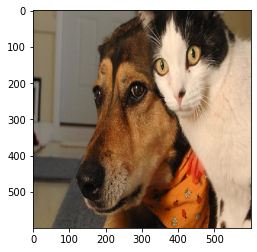

In [12]:
# Model name are EfficientNetB7,VGG16,VGG19,Resnet50,Xception,NASNetLarge.
model_name = 'EfficientNetB7'

model,img_size,preprocess_input,decode_predictions,last_conv_layer_name,classifier_layer_names = create_model(model_name)
print('Model : ',model_name)
print('The Last 10 layers : ',[i.name for i in model.layers][-10:])
print(f"Input img size : {img_size}")

# Read image, resize to the input size and convert to array
img_array = get_img_array(img_path, size=img_size)
img_array  = preprocess_input(img_array)
plt.imshow(img_array[0].astype(np.uint8))
plt.show()

In [13]:
# Print what the top predicted class is
preds = model.predict(img_array)

# Find top5 predictions
top5_class_name = [i[1] for i in decode_predictions(preds, top=5)[0]]
for i in range(preds.shape[1]):
    label = np.zeros((1,preds.shape[1]))
    label[0,i] = preds[0,i]
    class_name = decode_predictions(label, top=1)[0][0][1]
    if class_name in top5_class_name:
        print("Predicted classth:",i, decode_predictions(label, top=1)[0][0])

Predicted classth: 166 ('n02089867', 'Walker_hound', 0.17378228902816772)
Predicted classth: 208 ('n02099712', 'Labrador_retriever', 0.03105713240802288)
Predicted classth: 246 ('n02109047', 'Great_Dane', 0.030623961240053177)
Predicted classth: 273 ('n02115641', 'dingo', 0.02968847006559372)
Predicted classth: 285 ('n02124075', 'Egyptian_cat', 0.0810346007347107)


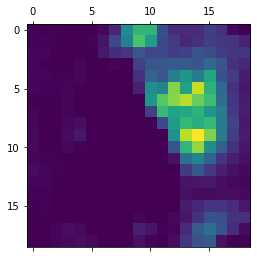

Heatmap.shape : (19, 19)


In [16]:
# Generate class activation heatmap
SELECTED_CLASSTH = 285 # 'Egyptian_cat'
_heatmap,last_conv_layer_output,pooled_grads,grads1,original_last_conv_layer_output,top_class_channe,preRelu_heatmap  = make_gradcam_heatmap(img_array, 
                                                                                                                                             model, 
                                                                                                                                             last_conv_layer_name, 
                                                                                                                                             classifier_layer_names,
                                                                                                                                             selected_classth=SELECTED_CLASSTH,
                                                                                                                                             softmax=True)

# Display heatmap
plt.matshow(_heatmap)
plt.show()
print(f'Heatmap.shape : {_heatmap.shape}')

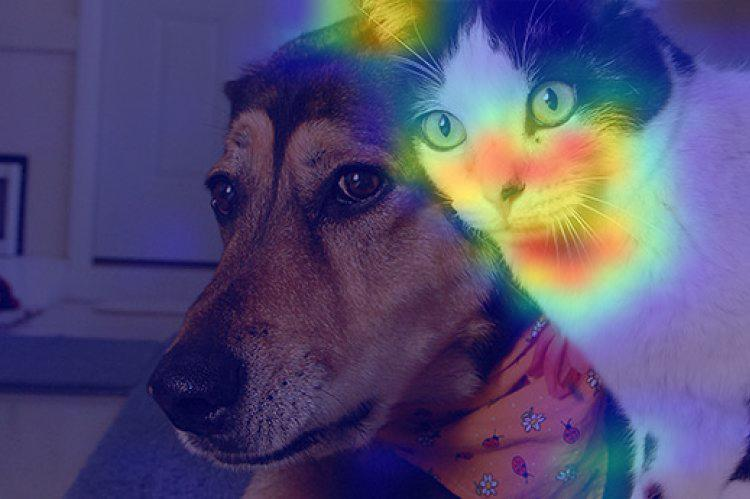

In [17]:
# We load the original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * _heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
array_jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = array_jet_heatmap * 0.8 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "image_sample.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

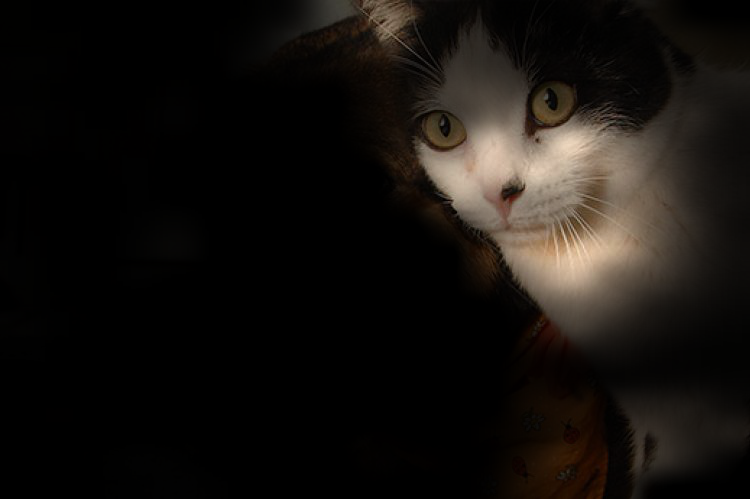

In [18]:
def bitwise_heatmap_img(heatmap,original_img):
    bit_heatmap = tf.keras.preprocessing.image.array_to_img(np.expand_dims(heatmap,axis=2))
    bit_heatmap = bit_heatmap.resize((original_img.shape[1], original_img.shape[0]))
    array_bit_heatmap = tf.keras.preprocessing.image.img_to_array(bit_heatmap)
    return bit_heatmap,tf.keras.preprocessing.image.array_to_img(array_bit_heatmap*original_img)

bit_heatmap,bitwise_img = bitwise_heatmap_img(_heatmap,img)
bitwise_img

## Guided backpropagation

In [19]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.python.framework import ops
from tensorflow.keras import backend as K

@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

# Reference: https://github.com/eclique/keras-gradcam with adaption to tensorflow 2.0  
class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        if self.layerName == None:
            self.layerName = self.find_target_layer()
        self.gbModel = self.build_guided_model()
        
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbModel
    
    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]

        saliency = cv2.resize(np.asarray(grads), upsample_size)
        
        saliency = cv2.cvtColor(saliency, cv2.COLOR_BGR2RGB)
        return saliency

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

102973440/102967424 [==============================] - 1s 0us/step
Model :  Resnet50
The Last 10 layers :  ['conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out', 'avg_pool', 'predictions']
Input img size : (224, 224)


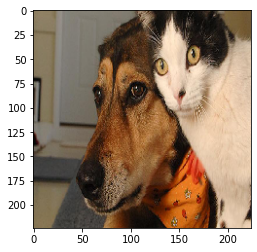

In [21]:
# Model name are EfficientNetB7,VGG16,VGG19,Resnet50,Xception,NASNetLarge.
model_name = 'Resnet50'

model,img_size,preprocess_input,decode_predictions,last_conv_layer_name,classifier_layer_names = create_model(model_name)
print('Model : ',model_name)
print('The Last 10 layers : ',[i.name for i in model.layers][-10:])
print(f"Input img size : {img_size}")

# Read image, resize to the input size and convert to array
img_array = get_img_array(img_path, size=img_size)
img_array  = preprocess_input(img_array)
plt.imshow(img_array[0].astype(np.uint8))
plt.show()

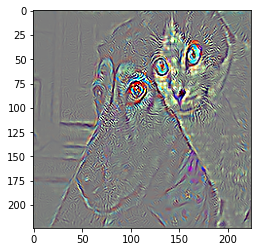

In [22]:
# Create a guide-dbackprop object. 
guidedBP = GuidedBackprop(model=model,layerName=None)

# We load the original image
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
H,W = img.shape[0:2]
H,W = (224,224)
# Read image, resize to the input size and convert to array
img_array = get_img_array(img_path, size=(224,224))
img_array  = preprocess_input(img_array)

upsample_size = (W,H)
gb = guidedBP.guided_backprop(img_array, upsample_size)
gb_im = deprocess_image(gb)
plt.imshow(gb_im)
plt.show()

##Guided gradCAM

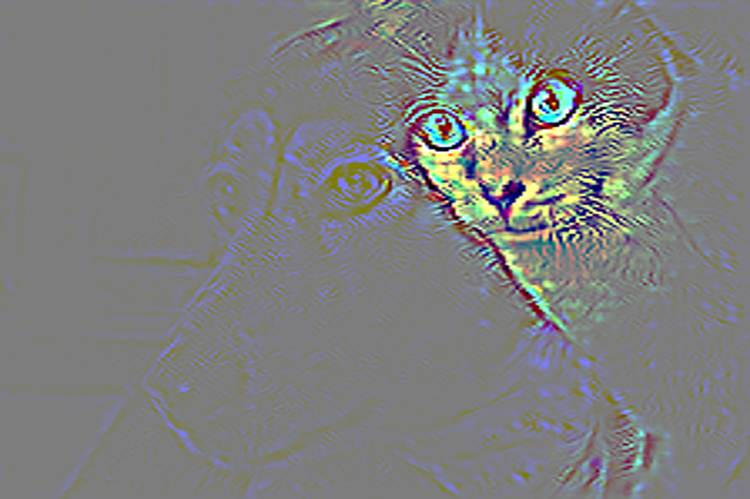

In [39]:
# Resize the heatmap
resized_heatmap = tf.keras.preprocessing.image.array_to_img(array_jet_heatmap)
resized_heatmap = resized_heatmap.resize((gb.shape[1],gb.shape[0]))
resized_heatmap = tf.keras.preprocessing.image.img_to_array(resized_heatmap)

# Generate guided gradCAM.
guided_gradcam = deprocess_image(gb *resized_heatmap)

# Resize guided_gradcam
resized_guided_gradcam = tf.keras.preprocessing.image.array_to_img(guided_gradcam)
resized_guided_gradcam = resized_guided_gradcam.resize((array_jet_heatmap.shape[1],array_jet_heatmap.shape[0]))
resized_guided_gradcam